In [ ]:
import requests
import matplotlib
from bs4 import BeautifulSoup
import re
import time
import pandas as pd
import geopandas as gpd
import ast
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.edge.options import Options
from webdriver_manager.microsoft import EdgeChromiumDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

## Corecivics facilities

In [205]:
url = 'https://www.corecivic.com/facilities'
corecivic_pg = requests.get(url)
corecivic_text = corecivic_pg.text

# extract facility names from the JavaScript code
matches = re.findall(r"position:\s*{lat:\s*([\d\.-]+),\s*lng:\s*([\d\.-]+)}.*?title:\s*'([^']*)'", corecivic_text, re.DOTALL)

# store the results in a structured format
facilities = []
for lat, lng, name in matches:
    facilities.append({
        'name' : name,
        'latitude' : float(lat),
        'longitude' : float(lng)
    })

# print extracted data
print("Extracted facilities with coordinates:")
for facility in facilities:
    print(f"{facility['name']}: ({facility['latitude']}, {facility['longitude']})")

corecivic_df = pd.DataFrame(facilities)

# create new column called coordinates for combined latitude and longitude
corecivic_df['coordinates'] = corecivic_df.apply(lambda row: (row['longitude'], row['latitude']), axis = 1)

Extracted facilities with coordinates:
Adams County Correctional Center: (31.55897, -91.22058)
Adams Transitional Center: (39.80885, -104.97006)
Allen Gamble Correctional Center (formerly Davis Correctional Facility): (35.09006, -96.44393)
Arapahoe Community Treatment Center: (39.655743, -105.029175)
Austin Residential Reentry Center: (30.202234, -97.64257)
Austin Transitional Center: (30.202234, -97.64257)
Bent County Correctional Facility: (38.066277, -103.20539)
Boston Avenue: (32.69353, -117.13503)
California City Correctional Center: (35.154705, -117.861916)
Centennial Community Transition Center: (39.58827, -104.82109)
Central Arizona Florence Correctional Complex: (33.04417, -111.37685)
Cheyenne Transitional Center: (41.13313, -104.81808)
Cibola County Correctional Center: (35.17948, -107.90791)
Cimarron Facility: (35.94391, -96.78048)
Citrus County Detention Facility: (28.84513, -82.47694)
Coffee Correctional Facility: (31.52459, -82.63512)
Commerce Transitional Center: (39.785

In [160]:
corecivic_df.to_csv("corecivic_df.csv", index = False)

## Geo Management Facilities

In [209]:
url = "https://www.geogroup.com/LOCATIONS"
geogrp_pg = requests.get(url)
geogrp_soup = BeautifulSoup(geogrp_pg.text, 'html.parser')

# print(geogrp_soup.prettify())

geo_facilities_name = []
geo_facilities_address = []

# extract facility name
facility_names = [
    a.text.strip()
    for a in geogrp_soup.select("#dvFacilityDetail .Location_Facility_Heading a")
]
# extract address of facility
facility_addresses = geogrp_soup.find_all("li", class_= "Location_Facility_BT_subtext")

for name, address in zip(facility_names, facility_addresses):
    facility_name = name
    facility_address = address.get_text(strip = True)

    geo_facilities_name.append(facility_name)
    geo_facilities_address.append(facility_address)

geo_facilities = [{'name' : n, 'address': a} for n, a in zip(geo_facilities_name, geo_facilities_address)]

geogrp_df = pd.DataFrame(geo_facilities)

aussie_fac_to_remove = ['Fulham Correctional Centre', 'Junee Correctional Centre', 'Kutama Sinthumule Correctional Centre', 'Ravenhall Correctional Centre', 'The GEO Group Australia Pty Ltd.']

# remove Australian 
geogrp_df = geogrp_df[~geogrp_df['name'].isin(aussie_fac_to_remove)]
geogrp_df.reset_index(drop = True, inplace = True)

In [207]:
geogrp_df.head(5)

,name,address
0,Adelanto ICE Processing Center,"10400 Rancho Road, Adelanto, CA 92301"
1,Alexandria Staging Facility,"96 George Thompson Drive, Alexandria, LA 71303"
2,Aurora ICE Processing Center,"3130 North Oakland Street, Aurora, CO 80010"
3,Big Spring Correctional Facility,"3711 Wright Avenue, Big Spring , TX 79720"
4,Blackwater River Correctional and Rehabilitati...,"5914 Jeff Ates Road, Milton, FL 32583"


In [ ]:
# extract latitude and longitude from address
# find the latitude and longitude for the ones that did not have it
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from geopy.extra.rate_limiter import RateLimiter
import numpy as np  # Import NumPy
from geopy.exc import GeocoderTimedOut
import time

geolocator = Nominatim(user_agent = "xxx")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 1)

def get_coordinates(address):

    try:
        # try to find the latitude and longitude of a given address
        location = geocode(address, timeout = 10)
        if location:
            print(f"Found latitude and longitude for {address}")
            return (location.longitude, location.latitude) if location else None
        else:
            print(f"No coordinates found for {address}")
            return None
        
    except GeocoderTimedOut:
        # if a request takes too long, it will return none and print a message to let us know
        print(f"Geocoder timed out for {address}")
        return None
    
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return None

geogrp_df['coordinates'] = geogrp_df['address'].apply(get_coordinates)


Found latitude and longitude for 10400 Rancho Road, Adelanto, CA 92301
No coordinates found for 96 George Thompson Drive, Alexandria, LA 71303
Found latitude and longitude for 3130 North Oakland Street, Aurora, CO 80010
Found latitude and longitude for 3711 Wright Avenue, Big Spring , TX 79720
Found latitude and longitude for 5914 Jeff Ates Road, Milton, FL 32583
Found latitude and longitude for 901 County Road 201, Falfurrias, TX 78355
Found latitude and longitude for 3900 North Powerline Road, Deerfield Beach, FL 33073
Found latitude and longitude for 1401 E. Diversion Dam Road, Florence, AZ 85132
No coordinates found for 830 Pinehill Road, PO Box 2826, Jena, LA 71342
No coordinates found for 1777 NE Loop 410, Suite 1100, San Antonio, TX 78217
Found latitude and longitude for 254 Taylor Avenue, McFarland, CA 93250
No coordinates found for 4909 FM 2826, Robstown, TX 78380
No coordinates found for 3262 Highway 252, Folkston , GA 31537
Found latitude and longitude for 10450 Rancho Rd, A

In [ ]:
geogrp_df.to_csv('geo_df.csv', index = False)
geogrp_df = pd.read_csv("C:/Users/michelle.iolow/OneDrive - crj.org/Desktop/privateprisons/geo_df.csv")

In [213]:
def convert_to_tuple(coord):
    if isinstance(coord, tuple):
        return coord  # Already a tuple, return as is
    elif isinstance(coord, str):
        # Extract numbers using regex
        match = re.findall(r"[-+]?\d*\.\d+|\d+", coord)
        if len(match) == 2:
            return (float(match[0]), float(match[1]))  # Convert to tuple
    return None  # Return None if conversion fails

# Apply conversion function to the 'coordinates' column
geogrp_df['coordinates'] = geogrp_df['coordinates'].apply(convert_to_tuple)

# Check if the conversion worked
# print(geogrp_df['coordinates'].apply(type).value_counts())

geogrp_df.to_csv('geo_df.csv', index = False)

In [212]:
geogrp_df = pd.read_csv("C:/Users/michelle.iolow/OneDrive - crj.org/Desktop/privateprisons/geo_df.csv")

## Combine the geo and corecivics into one dataframe

In [215]:
# read in the two files
corecivic_df = pd.read_csv("corecivic_df.csv")
geogrp_df = pd.read_csv("geo_df.csv")

In [216]:
# combine dataframe
privateprisons_df = pd.concat([geogrp_df, corecivic_df], ignore_index = True)

# add a column to label them as private prisons
privateprisons_df['private'] = 1

# label geo prisons and corecivic prisons
privateprisons_df['geoprison'] = privateprisons_df['latitude'].isna().astype(int)
privateprisons_df['corecivicprison'] = privateprisons_df['latitude'].notna().astype(int)

privateprisons_df.to_csv('privateprisons_df.csv', index = False)

## Extracting government prisons

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import json
import os
from selenium import webdriver
from selenium.webdriver.edge.options import Options
from selenium.webdriver.edge.service import Service
from webdriver_manager.microsoft import EdgeChromiumDriverManager
from selenium.webdriver.common.by import By

# create a directory for WebDriver if it doesn't exist
os.makedirs("webdriver_cache", exist_ok = True)

# start with the URL that has a list of links to all locations
gov_original_url = "https://www.bop.gov/locations/list.jsp"
gov_original_pg = requests.get(gov_original_url)
gov_soup = BeautifulSoup(gov_original_pg.text, 'html.parser')

# create a list to store facility links
gov_facility_links = []
for a in gov_soup.select("div.colDisplayList a[href^='/locations/institutions/']"):
    href = a.get("href")
    full_url = "https://www.bop.gov" + href
    gov_facility_links.append(full_url)

# function to start up webdriver
def setup_driver():
    """ set up and return the WebDriver with appropriate options """
    edge_options = Options()
    edge_options.add_argument("--headless")
    edge_options.add_argument("--no-sandbox")
    edge_options.add_argument("--disable-dev-shm-usage")
    
    try:
        # Create the driver with WebDriver Manager
        driver = webdriver.Edge(
            service=Service(EdgeChromiumDriverManager().install()), 
            options=edge_options
        )
        return driver
    except Exception as e:
        print(f"Error setting up Edge driver with WebDriver Manager: {e}")
        
        try:
            # if WebDriver Manager fails, this is our backup
            # Create the driver without WebDriver Manager
            # This assumes Edge driver is already installed
            driver = webdriver.Edge(options = edge_options)
            return driver
        except Exception as e:
            print(f"Error setting up Edge driver without WebDriver Manager: {e}")
            raise e

# function to pull facility name and address
def scrape_prison_data(url):
    try:
        # first attempt with requests/BeautifulSoup 
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # try to extract data with BeautifulSoup
        facility_title_elem = soup.find(id = "facility_title")

        if facility_title_elem and facility_title_elem.text.strip(): #strip() removes unnecessary spaces
            print("Using BeautifulSoup method - no Selenium needed")
            
            facility_name = facility_title_elem.text.strip()
            
            address_elem = soup.find(id="address")
            address = address_elem.text.strip() if address_elem else ""
            
            address2_elem = soup.find(id="address2")
            address2 = address2_elem.text.strip() if address2_elem else ""
            
            city_elem = soup.find(id="city")
            city = city_elem.text.strip() if city_elem else ""
            
            state_elem = soup.find(id="state")
            state = state_elem.text.strip() if state_elem else ""
            
            zip_elem = soup.find(id="zip_code")
            zip_code = zip_elem.text.strip() if zip_elem else ""
            
            # construct full address
            address_parts = [address]
            if address2:
                address_parts.append(address2)
            if city and state and zip_code:
                address_parts.append(f"{city}, {state} {zip_code}")
            
            full_address = ", ".join(filter(None, address_parts))
            
            return {
                "name": facility_name,
                "address": full_address,
                "street_address": address,
                "extended_address": address2,
                "city": city,
                "state": state,
                "zip_code": zip_code,
                "url": url,
                "method": "BeautifulSoup"
            }
        
        # this is when we know that beautifulsoup did not work
        print("BeautifulSoup method failed, trying Selenium...")
        
        # IF beautifulsoup does not work, we try Selenium
        # set up the driver
        driver = setup_driver()
        
        try:
            # navigate to the URL
            driver.get(url)
            time.sleep(5)  # give it time to load
            
            # get the page source
            page_source = driver.page_source
            soup = BeautifulSoup(page_source, 'html.parser')
            
            # extract facility name
            facility_title_elem = soup.find(id = "facility_title")
            facility_name = facility_title_elem.text.strip() if facility_title_elem else "Name not found"
            
            # extract address components
            address_elem = soup.find(id = "address")
            address = address_elem.text.strip() if address_elem else ""
            
            address2_elem = soup.find(id = "address2")
            address2 = address2_elem.text.strip() if address2_elem else ""
            
            city_elem = soup.find(id = "city")
            city = city_elem.text.strip() if city_elem else ""
            
            state_elem = soup.find(id = "state")
            state = state_elem.text.strip() if state_elem else ""
            
            zip_elem = soup.find(id = "zip_code")
            zip_code = zip_elem.text.strip() if zip_elem else ""
            
            # construct full address
            address_parts = [address]
            if address2:
                address_parts.append(address2)
            if city and state and zip_code:
                address_parts.append(f"{city}, {state} {zip_code}")
            
            full_address = ", ".join(filter(None, address_parts))
            
            return {
                "name": facility_name,
                "address": full_address,
                "street_address": address,
                "extended_address": address2,
                "city": city,
                "state": state,
                "zip_code": zip_code,
                "url": url,
                "method": "Selenium"
            }
        
        finally:
            driver.quit()
    
    except Exception as e:
        print(f"Error scraping {url}: {str(e)}")
        return {
            "name": "Error",
            "address": "Failed to scrape",
            "url": url,
            "error": str(e)
        }

# Process all links
links_to_process = gov_facility_links

# Create a list to store all prison data
all_prison_data = []

# Loop through each prison link to scrape the data
for i, link in enumerate(links_to_process):
    try:
        print(f"\nProcessing {i+1}/{len(links_to_process)}: {link}")
        prison_data = scrape_prison_data(link)
        all_prison_data.append(prison_data)
        print(f"Successfully scraped: {prison_data['name']}")
        
        # Add a delay between requests
        time.sleep(1)
    except Exception as e:
        print(f"Error in main loop for {link}: {e}")
        all_prison_data.append({
            "name": "Error",
            "address": "Failed to scrape",
            "url": link,
            "error": str(e)
        })

# Print summary
print(f"\nTotal prisons: {len(links_to_process)}")
print(f"Successful scrapes: {sum(1 for p in all_prison_data if p['name'] not in ['Error', 'Name not found'])}")

# Save results to a file
with open("prison_data.json", "w") as f:
    json.dump(all_prison_data, f, indent=2)
print("Results saved to prison_data.json")

# Convert the list of dictionaries into a pandas DataFrame
govprison_df = pd.DataFrame(all_prison_data)

# Save to a CSV file
govprison_df.to_csv("govprisons_df.csv", index=False)

print("Results saved to govprisons_df.csv")


Processing 1/83: https://www.bop.gov/locations/institutions/ald/
BeautifulSoup method failed, trying Selenium...
Successfully scraped: FPC Alderson

Processing 2/83: https://www.bop.gov/locations/institutions/ali/
BeautifulSoup method failed, trying Selenium...
Successfully scraped: FCI Aliceville

Processing 3/83: https://www.bop.gov/locations/institutions/ash/
BeautifulSoup method failed, trying Selenium...
Successfully scraped: FCI Ashland

Processing 4/83: https://www.bop.gov/locations/institutions/atl/
BeautifulSoup method failed, trying Selenium...
Successfully scraped: FCI Atlanta

Processing 5/83: https://www.bop.gov/locations/institutions/atw/
BeautifulSoup method failed, trying Selenium...
Successfully scraped: USP Atwater

Processing 6/83: https://www.bop.gov/locations/institutions/bas/
BeautifulSoup method failed, trying Selenium...
Successfully scraped: FCI Bastrop

Processing 7/83: https://www.bop.gov/locations/institutions/bec/
BeautifulSoup method failed, trying Seleni

In [217]:
govprisons_df = pd.read_csv('C:/Users/michelle.iolow/OneDrive - crj.org/Desktop/privateprisons/govprisons_df.csv')

In [219]:
# extract longitude and latitude from address
govprisons_df['coordinates'] = govprisons_df['address'].apply(get_coordinates)
govprisons_df.to_csv("govprisons_df.csv", index = False)

No coordinates found for GLEN RAY RD. BOX A, ALDERSON, WV 24910
No coordinates found for 11070 HIGHWAY 14, ALICEVILLE, AL 35442
No coordinates found for ST. ROUTE 716, ASHLAND, KY 41105
Found latitude and longitude for 601 MCDONOUGH BLVD SE, ATLANTA, GA 30315
Found latitude and longitude for 1 FEDERAL WAY, ATWATER, CA 95301
No coordinates found for 1341 HIGHWAY 95 NORTH, BASTROP, TX 78602
Found latitude and longitude for 1600 INDUSTRIAL ROAD, BEAVER, WV 25813
Found latitude and longitude for 696 MUCKERMAN ROAD, BENNETTSVILLE, SC 29512
Found latitude and longitude for 1 SUCCESS LOOP ROAD, BERLIN, NH 03570
Found latitude and longitude for 1197 AIRPORT ROAD, INEZ, KY 41224
No coordinates found for 1900 SIMLER AVE, BIG SPRING, TX 79720
Found latitude and longitude for 80 29TH STREET, BROOKLYN, NY 11232
Found latitude and longitude for 1100 URSULINE AVENUE, BRYAN, TX 77803
No coordinates found for 3057 ERIC J. WILLIAMS, MEMORIAL DRIVE, WAYMART, PA 18472
No coordinates found for NAVAL AIR ST

## Editing the two compiled dataframes

### gov prisons df

In [220]:
govprisons_df = pd.read_csv('C:/Users/michelle.iolow/OneDrive - crj.org/Desktop/privateprisons/govprisons_df.csv')

# add a column that indicates it as a gov prison
govprisons_df['govprisons'] = 1

### Private prisons df

In [221]:
# read in csv
privateprisons_df = pd.read_csv('C:/Users/michelle.iolow/OneDrive - crj.org/Desktop/privateprisons/privateprisons_df.csv')

### Merge both together

In [222]:
usprisons_df = pd.concat([govprisons_df, privateprisons_df], ignore_index = True)

In [226]:
print(usprisons_df.columns.tolist())

['name', 'address', 'coordinates', 'govprisons', 'private', 'geoprison', 'corecivicprison']


In [224]:
# fill out 0 for private prisons in the govprison column and 0 for gov prisons in the privateprison column
usprisons_df.loc[usprisons_df['private'] == 1, 'govprisons'] = 0
usprisons_df.loc[usprisons_df['private'].isna(), 'govprisons'] = 1

usprisons_df.loc[usprisons_df['govprisons'] == 1, 'private'] = 0
usprisons_df.loc[usprisons_df['govprisons'].isna(), 'private'] = 1

usprisons_df.loc[usprisons_df['geoprison'].isna(), 'geoprison'] = 0
usprisons_df.loc[usprisons_df['corecivicprison'].isna(), 'corecivicprison'] = 0

In [225]:
# drop unwanted columns
usprisons_df = usprisons_df.drop(columns = ['street_address',
                                 'extended_address', 'city', 
                                 'state', 'zip_code', 'url',
                                 'method', 'latitude', 'longitude'])

In [228]:
def convert_safely(coord):

    # if it is already a tuple, convert into Point
    if isinstance(coord, tuple):
        return Point(coord)
    
    elif isinstance(coord, str):

        # extract the numbers
        match = re.findall(r"[-+]?\d*\.\d+|\d+", coord)

        if len(match) == 2:
            return Point(float(match[0]), float(match[1]))
        
        return None # if we don't have valid data, we return None
    
usprisons_df['coordinates'] = usprisons_df['coordinates'].apply(convert_safely)
print(usprisons_df['coordinates'].apply(type).value_counts())

usprisons_df = gpd.GeoDataFrame(usprisons_df, geometry = 'coordinates')
usprisons_df.set_crs("EPSG: 4269", inplace = True)

usprisons_df.to_csv("usprisons_df.csv", index = False)

coordinates
<class 'shapely.geometry.point.Point'>    217
Name: count, dtype: int64


## Read in the shapefiles

In [227]:
shapefile_path = 'C:/Users/michelle.iolow/OneDrive - crj.org/Desktop/privateprisons'

us_states_shp = gpd.read_file(shapefile_path)

In [ ]:
usprisons_df = usprisons_df.set_geometry("coordinates")

us_states_shp = us_states_shp.to_crs(epsg=4326)
usprisons_df = usprisons_df.to_crs(epsg=4326)

### Plotting US boundaries with prison locations

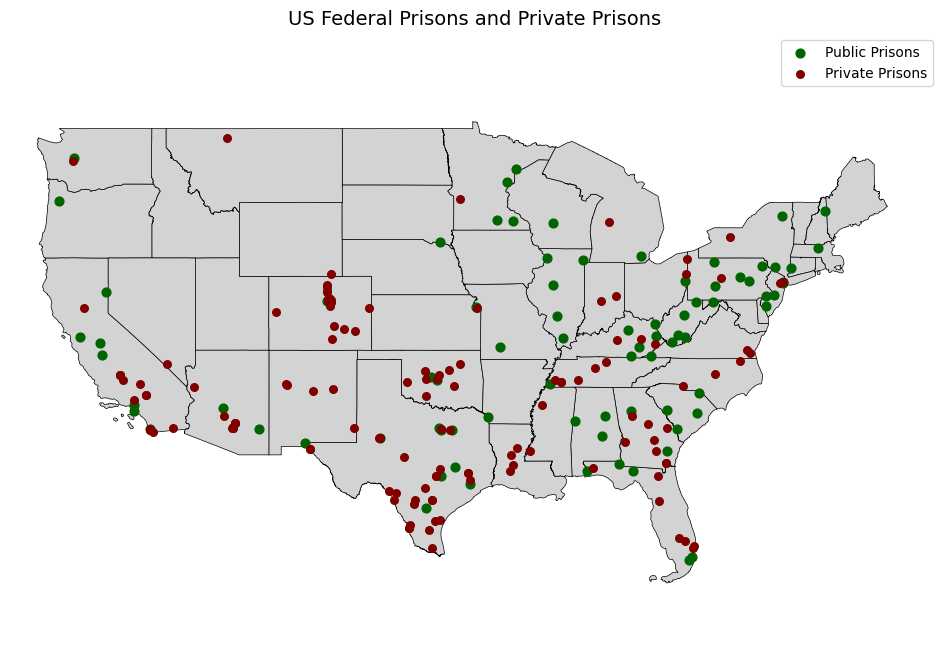

In [242]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (12, 8))
ax.set_aspect('equal', adjustable = 'datalim')

# plot main map (contiguous US)
us_states_shp.plot(ax = ax,
                  color = 'lightgrey',
                  edgecolor = "black",
                  linewidth = 0.5)

# set boundaries for contiguous US (so we don't see the territories, hawaii, and alaska)
ax.set_xlim([-125, -65])
ax.set_ylim([25, 50])

# # Create inset for Alaska
# # [x (position from left edge, 1% for left), y (position from bottom), width, height] in figure coordinates
# ax_alaska = fig.add_axes([0.01, 0.15, 0.25, 0.25])  
# alaska_mask = us_states_shp.NAME == 'Alaska' # create a filter that looks only at Alaska
# us_states_shp[alaska_mask].plot(ax = ax_alaska,
#                                color = 'lightgrey',
#                                edgecolor = "black",
#                                linewidth = 0.5)
# # ax_alaska.set_title("Alaska", fontsize = 10)
# ax_alaska.set_axis_off()

# # Create inset for Hawaii
# ax_hawaii = fig.add_axes([0.01, 0.5, 0.15, 0.15]) 
# hawaii_mask = us_states_shp.NAME == 'Hawaii' # create a filter for Hawaii
# us_states_shp[hawaii_mask].plot(ax = ax_hawaii,
#                                color = 'lightgrey',
#                                edgecolor = "black",
#                                linewidth = 0.5)
# # ax_hawaii.set_title("Hawaii", fontsize = 10)
# ax_hawaii.set_axis_off()

# plotting the prisons
publicprison = usprisons_df[usprisons_df['govprisons'] == 1]
privateprison = usprisons_df[usprisons_df['govprisons'] == 0]
publicprison = gpd.GeoDataFrame(publicprison, geometry='coordinates')
privateprison = gpd.GeoDataFrame(privateprison, geometry='coordinates')
publicprison = publicprison.set_crs(epsg=4326)
privateprison = privateprison.set_crs(epsg=4326)

publicprison.plot(ax = ax, color = 'darkgreen', markersize = 40, label = 'Public Prisons')
privateprison.plot(ax = ax, color = 'maroon', markersize = 30, label = 'Private Prisons')

# legend
plt.legend()

ax.set_title("US Federal Prisons and Private Prisons", fontsize = 14)
ax.set_axis_off()
plt.show()

## Pull states' partisan leaning data

In [247]:
pid_url = "https://www.presidency.ucsb.edu/statistics/elections/2024"
pid_pg = requests.get(pid_url)
pid_soup = BeautifulSoup(pid_pg.text, 'html.parser')
print(pid_soup.prettify())

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML+RDFa 1.0//EN"
  "http://www.w3.org/MarkUp/DTD/xhtml-rdfa-1.dtd">
<html dir="ltr" lang="en" prefix="content: http://purl.org/rss/1.0/modules/content/ dc: http://purl.org/dc/terms/ foaf: http://xmlns.com/foaf/0.1/ og: http://ogp.me/ns# rdfs: http://www.w3.org/2000/01/rdf-schema# sioc: http://rdfs.org/sioc/ns# sioct: http://rdfs.org/sioc/types# skos: http://www.w3.org/2004/02/skos/core# xsd: http://www.w3.org/2001/XMLSchema#">
 <head profile="http://www.w3.org/1999/xhtml/vocab">
  <meta charset="utf-8"/>
  <script type="text/javascript">
   (window.NREUM||(NREUM={})).init={ajax:{deny_list:["bam.nr-data.net"]}};(window.NREUM||(NREUM={})).loader_config={licenseKey:"dee899de70",applicationID:"80106271"};;/*! For license information please see nr-loader-rum-1.284.1.min.js.LICENSE.txt */
(()=>{var e,t,r={122:(e,t,r)=>{"use strict";r.d(t,{a:()=>i});var n=r(944);function i(e,t){try{if(!e||"object"!=typeof e)return(0,n.R)(3);if(!t||"object"!=typeof t)retur

In [ ]:
table = pid_soup.find('table')
rows = table.find_all('tr')

In [ ]:
election_data = []

for row in rows[1:]: #skipping the header row
    columns = row.find_all('td')

    # we only want the first 8 columns
    if len(columns) > 7:
        state = columns[0].get_text(strip = True)
        harris_pct = columns[3].get_text(strip = True)
        trump_pct = columns[6].get_text(strip = True)

        election_data.append({
            'State' : state,
            'Harris_Percentage' : harris_pct,
            'Trump_Percentage' : trump_pct
        })

for data in election_data:
    print(f"{data['State']}: Harris {data['Harris_Percentage']}, Trump {data['Trump_Percentage']}")

In [261]:
election24_df = pd.DataFrame(election_data[3:], columns = ['State', 'Harris_Percentage', 'Trump_Percentage'])
election24_df['Harris_Percentage'] = election24_df['Harris_Percentage'].str.replace('%', '').astype(float)
election24_df['Trump_Percentage'] = election24_df['Trump_Percentage'].str.replace('%', '').astype(float)

In [263]:
# looking at the net vote share for each state (-1 for trump landslide, 1 for harris landslide)
election24_df['Net_Vote_Share'] = (election24_df['Harris_Percentage'] - election24_df['Trump_Percentage'])/100

In [ ]:
# rename State in election24_df to NAME
election24_df = election24_df.rename(columns = {'State' : 'NAME'})

# merge election net vote share with the shapefile
us_states_elect_gdf = pd.merge(election24_df, us_states_shp, on = 'NAME')

In [322]:
print("berlin" in plt.colormaps())

False


In [277]:
# turn new dataframe into a geopandas dataframe
us_states_elect_gdf = gpd.GeoDataFrame(us_states_elect_gdf, geometry = 'geometry')
us_states_elect_gdf = us_states_elect_gdf.to_crs(epsg=4326)

## Plot the election data over map

In [321]:
print(matplotlib.__version__)

3.9.2


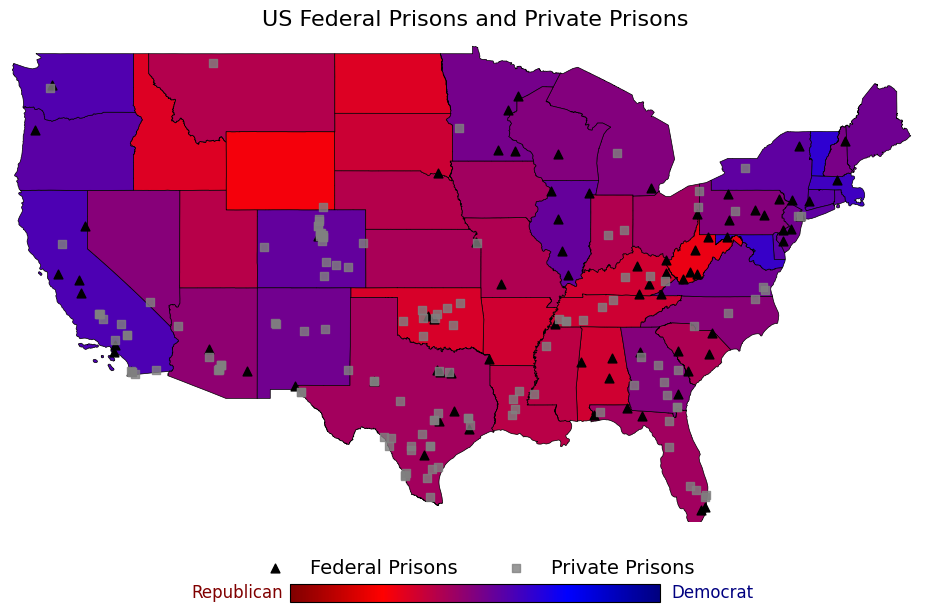

In [346]:
from matplotlib.colors import LinearSegmentedColormap

# creating custom color scale
colors = [
    (0.5, 0, 0),      # dark red
    (1, 0, 0),        # red
    (0.5, 0, 0.5),    # purple
    (0, 0, 1),        # blue
    (0, 0, 0.5)       # dark blue
]

cmap_name = 'red_purple_blue'
n_bins = 256  # Number of discrete colors in the colormap
pid_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

fig, ax = plt.subplots(figsize = (12, 8))

# plot the map
us_states_elect_gdf.plot(ax = ax, 
                         column = 'Net_Vote_Share',
                         cmap = pid_cmap,
                         alpha = 1,
                         edgecolor = 'black',
                         linewidth = 0.5, 
                         vmin = -1, vmax = 1,
                         legend = False)

# set boundaries for contiguous US (so we don't see the territories, hawaii, and alaska)
ax.set_xlim([-125, -65])
ax.set_ylim([25, 50])

# create the colorbar manually
sm = cm.ScalarMappable(cmap = pid_cmap, norm = mcolors.Normalize(vmin = -1, vmax = 1))
cbar = fig.colorbar(sm, ax = ax, orientation = 'horizontal', fraction = 0.03, pad = 0.1)
# remove color bar ticks
cbar.ax.set_xticks([])
cbar.ax.text(-0.02, 0.5, 'Republican', va = 'center', ha = 'right', fontsize = 12, transform = cbar.ax.transAxes, color = 'maroon')
cbar.ax.text(1.03, 0.5, 'Democrat', va = 'center', ha = 'left', fontsize = 12, transform = cbar.ax.transAxes, color = 'navy')


# plotting the prisons
publicprison = usprisons_df[usprisons_df['govprisons'] == 1]
privateprison = usprisons_df[usprisons_df['govprisons'] == 0]
publicprison = gpd.GeoDataFrame(publicprison, geometry='coordinates')
privateprison = gpd.GeoDataFrame(privateprison, geometry='coordinates')
publicprison = publicprison.set_crs(epsg=4326)
privateprison = privateprison.set_crs(epsg=4326)

publicprison.plot(ax = ax, color = 'black', markersize = 40, marker = '^',
                  label = 'Federal Prisons')
privateprison.plot(ax = ax, color = 'grey', markersize = 30, marker = 's',
                   alpha = 0.8, label = 'Private Prisons')

# prison legend
legend = ax.legend(loc = 'lower center', 
                   bbox_to_anchor = (0.5, -0.15),
                   ncol = 2,
                   frameon = False,
                   fontsize = 14)

ax.set_axis_off()
ax.set_title("US Federal Prisons and Private Prisons", fontsize = 16)


plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (12, 8))
ax.set_aspect('equal', adjustable = 'datalim')

# plot main map (contiguous US)
us_states_shp.plot(ax = ax,
                  color = 'lightgrey',
                  edgecolor = "black",
                  linewidth = 0.5)

# set boundaries for contiguous US (so we don't see the territories, hawaii, and alaska)
ax.set_xlim([-125, -65])
ax.set_ylim([25, 50])

# plotting the prisons
publicprison = usprisons_df[usprisons_df['govprisons'] == 1]
privateprison = usprisons_df[usprisons_df['govprisons'] == 0]
publicprison = gpd.GeoDataFrame(publicprison, geometry='coordinates')
privateprison = gpd.GeoDataFrame(privateprison, geometry='coordinates')
publicprison = publicprison.set_crs(epsg=4326)
privateprison = privateprison.set_crs(epsg=4326)

publicprison.plot(ax = ax, color = 'darkgreen', markersize = 40, label = 'Public Prisons')
privateprison.plot(ax = ax, color = 'maroon', markersize = 30, label = 'Private Prisons')


# plotting the election results


# legend
plt.legend()

ax.set_title("US Federal Prisons and Private Prisons", fontsize = 14)
ax.set_axis_off()
plt.show()